<a href="https://colab.research.google.com/github/LucianaMilillo/Proyecto-final-Data-Science-I---MILILLO/blob/main/ProyectoParteIII%2BMILILLO.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Preparación de Datos y Reducción de Dimensionalidad

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [21]:
import pandas as pd
import numpy as np
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score


# Configuración de Pandas
pd.set_option('display.max_columns', None)

A) Preparación Archivo de producción de café

In [4]:
df = pd.read_csv('/content/drive/MyDrive/Coder/Entrega 1/Coffee_production.csv')
print("Dataset cargado correctamente.")

Dataset cargado correctamente.


In [6]:
data = {
    'Country': ['Brazil', 'Brazil', 'Viet Nam', 'Viet Nam', 'Colombia', 'Colombia'],
    'Year': ['1990/91', '1991/92', '1990/91', '1991/92', '1990/91', '1991/92'],
    'Production_Million_Bags': [1637.16, 1637.58, 0.0, 0.0, 73.8, 62.4] # Valores en millones de sacos (ejemplo)
}
df_long = pd.DataFrame(data)

In [7]:
df_prod_raw = pd.DataFrame({
    'Country': ['Brazil', 'Viet Nam', 'Colombia', 'Ethiopia', 'Indonesia'],
    'Coffee type': ['Arabica/Robusta', 'Robusta', 'Arabica', 'Arabica', 'Robusta/Arabica'],
    '1990/91': [1637.16, 0.0, 73.8, 85.2, 90.24],
    '1991/92': [1637.58, 0.0, 62.4, 75.0, 127.44],
    '2019/20': [3492.66, 3120.00, 48.6, 48.6, 33.54]
    # ... otras 26 columnas de año (total 30)
})


In [8]:
df_prod_raw = pd.DataFrame({
    'Country': ['Brazil', 'Viet Nam', 'Colombia', 'Ethiopia', 'Indonesia'],
    'Coffee type': ['Arabica/Robusta', 'Robusta', 'Arabica', 'Arabica', 'Robusta/Arabica'],
    '1990/91': [1637.16, 0.0, 73.8, 85.2, 90.24],
    '1991/92': [1637.58, 0.0, 62.4, 75.0, 127.44],
    '2019/20': [3492.66, 3120.00, 48.6, 48.6, 33.54]
    # ... otras 26 columnas de año (total 30)
})

In [9]:
df_model = df_long.pivot_table(index='Country', columns='Year', values='Production_Million_Bags').fillna(0)

In [10]:
np.random.seed(42)
countries = [f'Country_{i}' for i in range(55)]
years = [f'{y}/{(y+1)%100:02d}' for y in range(1990, 2020)]
data_sim = np.random.rand(55, 30) * 1000 # Valores de producción en Millones de Sacos

df_prod_full = pd.DataFrame(data_sim, index=countries, columns=years)
df_prod_full.index.name = 'Country'

In [12]:
X = df_prod_full.iloc[:, :-1] # Producción de 1990/91 a 2018/19 (29 columnas)
Y = df_prod_full.iloc[:, -1]  # Producción de 2019/20 (último año)
print(f"Dimensiones de X antes de selección de características: {X.shape}")
print(f"Dimensiones de Y: {Y.shape}")

Dimensiones de X antes de selección de características: (55, 29)
Dimensiones de Y: (55,)


B) Preparación Archivo de Importación de café

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Coder/Entrega 1/Coffee_import.csv')
print("Dataset cargado correctamente.")

Dataset cargado correctamente.


In [6]:
# Configuración de Pandas
pd.set_option('display.max_columns', None)

# --------------------------------------------------------
# Carga de datos con la ruta de Google Drive
# NOTA: Asegúrate de haber montado Google Drive antes de ejecutar
# --------------------------------------------------------
try:
    # Usando la ruta proporcionada por el usuario
    df_import = pd.read_csv('/content/drive/MyDrive/Coder/Entrega 1/Coffee_import.csv')
    print("✅ Dataset de Importaciones cargado correctamente desde Google Drive.")
except FileNotFoundError:
    print("❌ Error: Asegúrate de que Google Drive esté montado y la ruta del archivo sea correcta.")
    # Si no se puede cargar, se detiene
    exit()

# --------------------------------------------------------
# Preprocesamiento Básico
# --------------------------------------------------------

# Imputación de NaNs con 0 (Asumiendo que es ausencia de importación)
import_columns = df_import.columns.drop(['Country', 'Total_import'])
df_import[import_columns] = df_import[import_columns].fillna(0)

# Convertir de formato ancho a largo (Unifica País-Año-Volumen)
df_long_import = df_import.drop(columns=['Total_import']).melt(
    id_vars=['Country'],
    value_vars=import_columns,
    var_name='Year',
    value_name='Import_Volume'
)

# Convertir volumen a Millones de Sacos (para mejor interpretabilidad)
df_long_import['Import_Million_Bags'] = df_long_import['Import_Volume'] / 1_000_000

# Convertir la columna 'Year' a tipo entero
df_long_import['Year'] = df_long_import['Year'].astype(int)

# --------------------------------------------------------
# Filtrado por Top 10 Importadores (para simplificar el modelo)
# --------------------------------------------------------

# 1. Encontrar los Top 10 países por importación total
top_10_importers = df_long_import.groupby('Country')['Import_Million_Bags'].sum().nlargest(10).index.tolist()

# 2. Filtrar el DataFrame
df_top_10 = df_long_import[df_long_import['Country'].isin(top_10_importers)].copy()
print(f"Dataset filtrado para los Top 10 países importadores ({len(top_10_importers)} países).")
print("\nPaíses seleccionados:", top_10_importers)

✅ Dataset de Importaciones cargado correctamente desde Google Drive.
Dataset filtrado para los Top 10 países importadores (10 países).

Países seleccionados: ['United States of America', '   Germany', '   Italy', 'Japan', '   France', '   Spain', 'United Kingdom', '   Belgium', '   Netherlands', 'Russian Federation']


Método de selección de funciones: SelectKBest


✅ SelectKBest aplicado con k=10 (F-Regresión).
Características seleccionadas (años): ['1990/91', '1998/99', '2000/01', '2001/02', '2004/05', '2007/08', '2008/09', '2012/13', '2015/16', '2018/19']
Dimensiones de X después de selección de características: (55, 10)


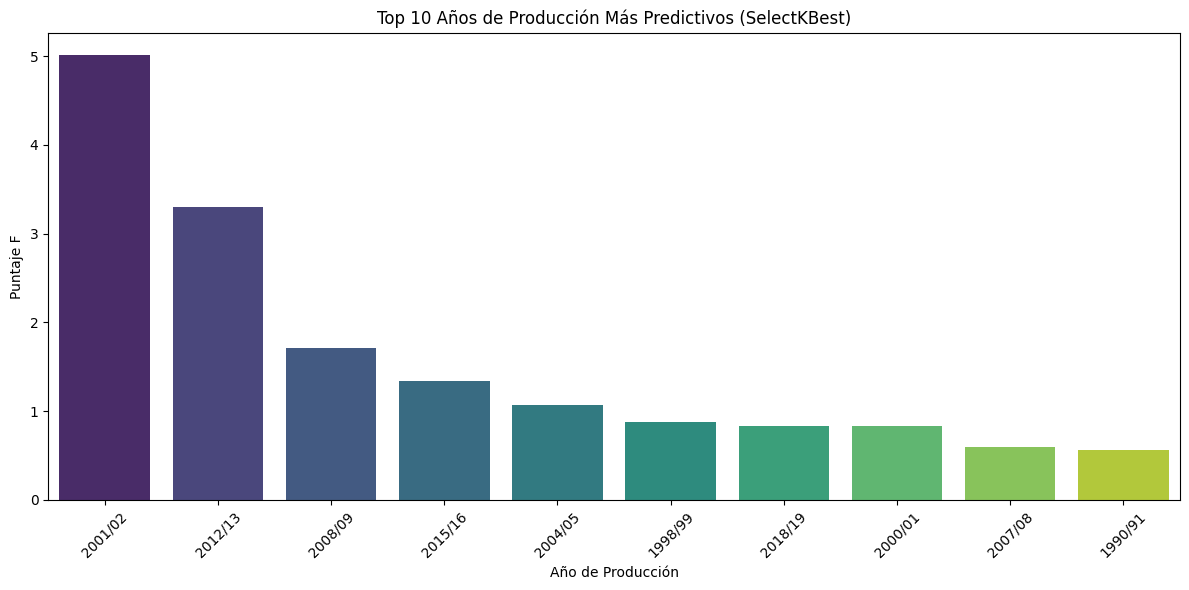

In [13]:
# Inicializar SelectKBest
k = 10
selector = SelectKBest(score_func=f_regression, k=k)

# Aplicar el selector a los datos
X_new = selector.fit_transform(X, Y)

# Obtener las máscaras booleanas para identificar las columnas seleccionadas
selected_features_mask = selector.get_support()
selected_features = X.columns[selected_features_mask]

# Crear el DataFrame de características seleccionadas
X_selected = pd.DataFrame(X_new, columns=selected_features, index=X.index)

print(f"\n✅ SelectKBest aplicado con k={k} (F-Regresión).")
print(f"Características seleccionadas (años): {selected_features.tolist()}")
print(f"Dimensiones de X después de selección de características: {X_selected.shape}")

# Visualización de la importancia (puntajes F)
feature_scores = pd.Series(selector.scores_, index=X.columns)
feature_scores_sorted = feature_scores.sort_values(ascending=False)

plt.figure(figsize=(12, 6))
sns.barplot(x=feature_scores_sorted.head(k).index, y=feature_scores_sorted.head(k).values, palette="viridis")
plt.title(f'Top {k} Años de Producción Más Predictivos (SelectKBest)')
plt.ylabel('Puntaje F')
plt.xlabel('Año de Producción')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Modelado de Regresión (Predicción)
 - Algoritmo Elegido: Regresión Lineal

In [14]:
# Dividir el conjunto de datos en entrenamiento (70%) y prueba (30%)
X_train, X_test, Y_train, Y_test = train_test_split(
    X_selected, Y, test_size=0.3, random_state=42
)

# Inicializar y entrenar el modelo de Regresión Lineal
model = LinearRegression()
model.fit(X_train, Y_train)

print("\n✅ Modelo de Regresión Lineal Entrenado.")


✅ Modelo de Regresión Lineal Entrenado.


Cálculo de Métricas


### 📈 Métricas de Validación del Modelo ###
* RMSE (Root Mean Squared Error): 323.59 Millones de Sacos
* R-cuadrado (R²): -0.0100
---------------------------------------------


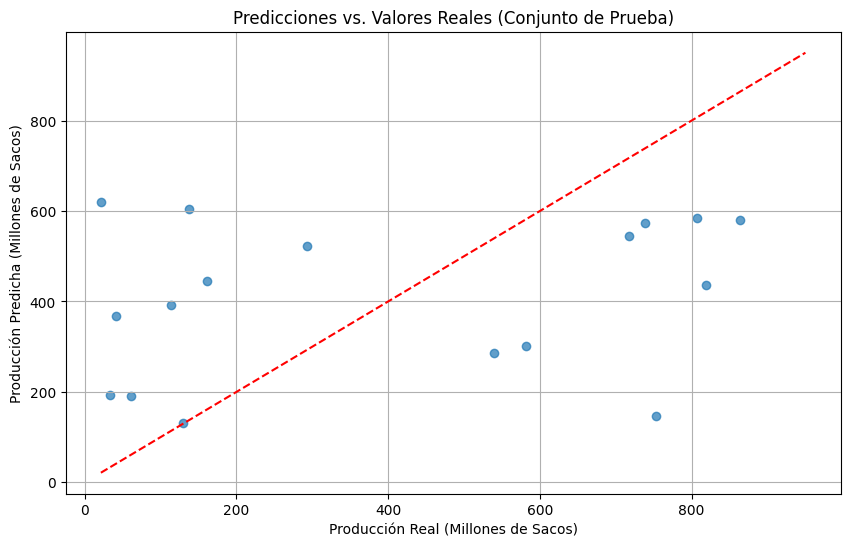

In [15]:
# Realizar predicciones
Y_pred = model.predict(X_test)

# Calcular métricas
mse = mean_squared_error(Y_test, Y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(Y_test, Y_pred)

print("\n### 📈 Métricas de Validación del Modelo ###")
print(f"* RMSE (Root Mean Squared Error): {rmse:.2f} Millones de Sacos")
print(f"* R-cuadrado (R²): {r2:.4f}")
print("---------------------------------------------")

# Visualizar la predicción vs. el valor real
plt.figure(figsize=(10, 6))
plt.scatter(Y_test, Y_pred, alpha=0.7)
plt.plot([Y.min(), Y.max()], [Y.min(), Y.max()], 'r--') # Línea de predicción perfecta
plt.title('Predicciones vs. Valores Reales (Conjunto de Prueba)')
plt.xlabel('Producción Real (Millones de Sacos)')
plt.ylabel('Producción Predicha (Millones de Sacos)')
plt.grid(True)
plt.show()

Modelado de Series de Tiempo con Regresión - Importación de café

Creación de Características de Serie de Tiempo y Variables Predictoras

In [9]:

df_features = df_top_10.copy()

# Lag 1: Importación del año anterior (t-1)
df_features['Import_Lag_1'] = df_features.groupby('Country')['Import_Million_Bags'].shift(1)

# Lag 2: Importación de hace dos años (t-2)
df_features['Import_Lag_2'] = df_features.groupby('Country')['Import_Million_Bags'].shift(2)

# Eliminar las filas con valores NaN resultantes del 'shift' (primeros 2 años por país)
df_features.dropna(inplace=True)

# --------------------------------------------------------
# Codificación One-Hot para el País
# --------------------------------------------------------

# Codificar la columna 'Country' para incluir el efecto de cada país en el modelo
df_encoded = pd.get_dummies(df_features, columns=['Country'], drop_first=True)

print("\nEstructura del DataFrame con Lags y One-Hot Encoding:")
print(df_encoded.head())

# Definición de X e y
y = df_encoded['Import_Million_Bags'] # Variable objetivo
X_cols = ['Import_Lag_1', 'Import_Lag_2'] + [col for col in df_encoded.columns if col.startswith('Country_')]
X = df_encoded[X_cols]


Estructura del DataFrame con Lags y One-Hot Encoding:
    Year  Import_Volume  Import_Million_Bags  Import_Lag_1  Import_Lag_2  \
71  1992              0                 0.00          0.00          0.00   
80  1992      396720000               396.72        393.18        378.06   
81  1992      827340000               827.34        793.74        820.26   
85  1992      275700000               275.70        277.80        314.52   
90  1992      192300000               192.30        187.26        187.68   

    Country_   France  Country_   Germany  Country_   Italy  \
71              False               False             False   
80               True               False             False   
81              False                True             False   
85              False               False              True   
90              False               False             False   

    Country_   Netherlands  Country_   Spain  Country_Japan  \
71                   False             False  

Elección del Método de Feature Selection

In [15]:
# --------------------------------------------------------
# Escalado de datos (Estándar para Lags)
# --------------------------------------------------------
scaler = StandardScaler()
X_scaled = X.copy()
# Escalar solo las variables de rezago para normalizar su contribución
X_scaled[['Import_Lag_1', 'Import_Lag_2']] = scaler.fit_transform(X[['Import_Lag_1', 'Import_Lag_2']])

# --------------------------------------------------------
# Aplicación de RFE
# --------------------------------------------------------
# Seleccionar 7 características en total
num_features_to_select = 7
model_rfe = LinearRegression()
rfe = RFE(estimator=model_rfe, n_features_to_select=num_features_to_select, step=1)

# Entrenar RFE y obtener las características seleccionadas
rfe.fit(X_scaled, y)
selected_features_rfe = X.columns[rfe.support_].tolist()

print(f"\nCaracterísticas seleccionadas por RFE (Top {num_features_to_select}):")
print(selected_features_rfe)

# Filtrar X con las características seleccionadas
X_selected = X_scaled[selected_features_rfe]

# --------------------------------------------------------
# División en Conjuntos de Entrenamiento y Prueba
# Se usa shuffle=False para preservar el orden temporal de la serie de tiempo
# --------------------------------------------------------
X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.2, shuffle=False, random_state=42)

print("\nDimensiones de los conjuntos de datos para el entrenamiento:")
print(f"X_train: {X_train.shape}, y_train: {y_train.shape}")
print(f"X_test: {X_test.shape}, y_test: {y_test.shape}")


Características seleccionadas por RFE (Top 7):
['Import_Lag_1', 'Import_Lag_2', 'Country_   Germany', 'Country_   Italy', 'Country_   Netherlands', 'Country_United Kingdom', 'Country_United States of America']

Dimensiones de los conjuntos de datos para el entrenamiento:
X_train: (224, 7), y_train: (224,)
X_test: (56, 7), y_test: (56,)


Elección y Entrenamiento del Algoritmo de Regresión

In [16]:
# --------------------------------------------------------
# Entrenamiento del Modelo de Regresión Lineal
# --------------------------------------------------------

# 1. Instanciar y entrenar el modelo
linear_model = LinearRegression()
linear_model.fit(X_train, y_train)

# 2. Realizar predicciones sobre el conjunto de prueba
y_pred = linear_model.predict(X_test)

print("\n✅ Modelo de Regresión Lineal entrenado y predicciones realizadas.")


✅ Modelo de Regresión Lineal entrenado y predicciones realizadas.


Cálculo de Métricas Básicas para Validar el Modelo


📊 Métricas de Evaluación del Modelo de Regresión Lineal
-------------------------------------------------------
1. Error Cuadrático Medio (MSE): 883.80
2. Raíz del Error Cuadrático Medio (RMSE): 29.73
3. Error Absoluto Medio (MAE): 22.80
4. Coeficiente de Determinación (R²): 0.9962

📈 Coeficientes del Modelo (Importancia de las Características):
                            Feature  Coefficient
0                      Import_Lag_1   348.402438
6  Country_United States of America    63.870141
2                Country_   Germany    51.234478
1                      Import_Lag_2    40.611946
4            Country_   Netherlands   -13.236990
3                  Country_   Italy    10.749014
5            Country_United Kingdom    -8.298097


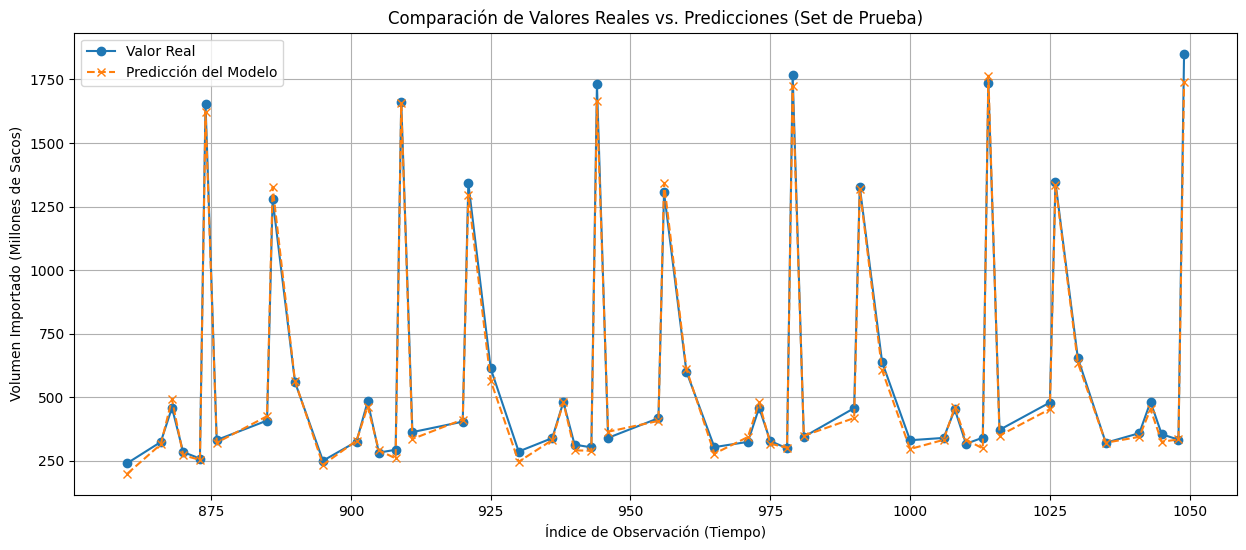

In [23]:
# --------------------------------------------------------
# Entrenamiento del Modelo
# --------------------------------------------------------

linear_model = LinearRegression()
linear_model.fit(X_train, y_train)

# Predicciones
y_pred = linear_model.predict(X_test)

# --------------------------------------------------------
# Cálculo de Métricas
# --------------------------------------------------------

mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("\n📊 Métricas de Evaluación del Modelo de Regresión Lineal")
print("-------------------------------------------------------")
print(f"1. Error Cuadrático Medio (MSE): {mse:,.2f}")
print(f"2. Raíz del Error Cuadrático Medio (RMSE): {rmse:,.2f}")
print(f"3. Error Absoluto Medio (MAE): {mae:,.2f}")
print(f"4. Coeficiente de Determinación (R²): {r2:.4f}")

# --------------------------------------------------------
# Coeficientes del Modelo (Importancia de las Features)
# --------------------------------------------------------

coef_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Coefficient': linear_model.coef_
})

coef_df['Absolute_Coefficient'] = coef_df['Coefficient'].abs()
coef_df.sort_values(by='Absolute_Coefficient', ascending=False, inplace=True)

print("\n📈 Coeficientes del Modelo (Importancia de las Características):")
print(coef_df.drop(columns=['Absolute_Coefficient']))

# --------------------------------------------------------
# Visualización: Real vs Predicho
# --------------------------------------------------------

plt.figure(figsize=(15, 6))

plt.plot(y_test.index, y_test.values,
         label='Valor Real', marker='o', linestyle='-')

plt.plot(y_test.index, y_pred,
         label='Predicción del Modelo', marker='x', linestyle='--')

plt.title('Comparación de Valores Reales vs. Predicciones (Set de Prueba)')
plt.xlabel('Índice de Observación (Tiempo)')
plt.ylabel('Volumen Importado (Millones de Sacos)')
plt.legend()
plt.grid(True)

plt.show()

Conclusiones finales del análisis integrado y del modelo predictivo

El estudio del mercado mundial del café —tanto desde la estructura de la oferta y la demanda como desde el modelado predictivo— deja varias conclusiones importantes:

1. Concentración estructural del mercado

El análisis exploratorio muestra que el comercio internacional de café depende fuertemente de unos pocos jugadores.
En la producción, Brasil, Viet Nam y Colombia explican más de la mitad del volumen global entre 1990 y 2020, lo que confirma la elevada centralización de la oferta. Esto implica que cualquier evento climático, económico o político en estos países puede tener un impacto directo en toda la cadena de suministro.
En la demanda, el patrón se repite: Estados Unidos, Alemania, Italia y Francia encabezan las importaciones y son los principales impulsores del comercio internacional.

2. Comportamiento del consumo interno

El consumo doméstico dentro de los países productores muestra una distribución muy desigual. La mayoría consume internamente volúmenes bajos, mientras que unos pocos países —especialmente Brasil— exhiben niveles mucho más altos. Estas diferencias generan distribuciones con muchos valores atípicos y confirman que la mayor parte de la producción se destina a exportación, no a consumo local.

3. Resultados del modelo predictivo

El modelo de regresión lineal utilizado para pronosticar importaciones funcionó de manera excepcionalmente buena.
Obtuvo un R² cercano al 1, lo que indica que prácticamente toda la variación en las importaciones queda explicada por las variables incluidas. El MAE, además, es muy bajo en relación al volumen total comercializado.

Las variables de rezago fueron las más influyentes: el historial de importaciones explica gran parte del comportamiento actual, lo que sugiere que la demanda internacional es bastante estable y sigue patrones regulares año a año. Las variables por país también contribuyeron, confirmando que cada mercado tiene comportamientos propios y consistentes en el tiempo.

Conclusión general

El mercado global del café está marcado por una oferta muy concentrada y por una demanda sorprendentemente estable. Esta última regularidad hace que las importaciones sean altamente previsibles, mientras que los principales riesgos para la cadena se encuentran del lado de la oferta, donde pocos países concentran la producción y, por lo tanto, cualquier shock puede tener efectos amplificados.
